In [1]:
import string
import re
import os
import tempfile
import logging
import csv
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from datetime import datetime
from gensim import corpora
from gensim import models
from gensim.corpora import Dictionary
from collections import namedtuple
import gensim.parsing.preprocessing as processing
from os import listdir
import CustomApi as api
#Start Global Variables and Types

#document dir
docs = "../data/documents/"

#Number of topics the model should index
numberOfTopics = 225

#Number of passes the model should make
passes = 75

#Keyphrase tracker
keyphraseTracker = api.KeyWordTracker()

#End Global Variables and Types

C:\Users\hp-pc\Anaconda3\envs\p2\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
files = listdir(docs+"lt2006/")
entries = []
for file in files:
    with open(docs+"lt2006/"+file,"rb") as csvfile:
        spamreader = csv.reader(csvfile)
        for row in spamreader:
            if "Authors" not in row[0] and row[15] !='[No abstract available]':
                entries.append(row)
        

In [3]:
files1 = listdir(docs+"gt2006/")

for file in files1:
    with open(docs+"gt2006/"+file,"rb") as csvfile:
        spamreader = csv.reader(csvfile)
        for row in spamreader:
            if "Authors" not in row[0] and row[15] !='[No abstract available]':
                entries.append(row)
        

In [4]:
# Create a set of frequent words
stopFile = open("../data/stopwords.txt","r")
stopWords = stopFile.read().splitlines() #This is the copyright symbol, this shows up in every abstract and should not be apart of the corpus
stopWords.extend([u"\u2019",u"\u03bc","bee","bees","honey","honeybee","honeybees",u"\xa9",u"\xc2"])
# for asc in range(97,123):
#     stopWords.extend([chr(asc)])
with open("../data/extraStopWords.txt","r") as extraStopFile:
    stopWords.extend(extraStopFile.read().split("\n"))
# Lowercase each document, split it by white space and filter out stopWords
stopList = set(stopWords)
processing.STOPWORDS = stopList
ps = PorterStemmer()
def removeStops(text):
    stopsRemoved = processing.remove_stopwords(text.lower().translate(None, string.punctuation))
    words = stopsRemoved.split(" ")
    stemmedWords = []
    for w in words:
        if len(ps.stem(w)) > 2:
            stemmedWords.append(ps.stem(w))
    return ' '.join(stemmedWords)
# Each abstract has a 'title':String, 'date':datetime.datetime, 'text':String, and 'keywords':String
abstracts = [api.MyAbstract._make([art[1],datetime.strptime(art[2], '%Y'),removeStops(art[15]), art[16]]) for art in entries]
abstracts.sort(key=lambda q: q.date.year)
entries = None
# Count word frequencies
selections = []

access = lambda x: x.date.year
lastIndex = 0
for i in range(1957,2019):
    index = api.binarySearch(abstracts,i,access)
    if  index != -1:
        selections.append(abstracts[lastIndex:index+1])
        lastIndex = index+1
        

In [7]:
from itertools import combinations
size = 0
start = 0
df_year=[]
df_new_keyword=[]
selection_edge=[]
keyphraseTracker1 = api.KeyWordTracker()
for i in range(0,len(selections)):
    keyphraseTracker = api.KeyWordTracker()
    keyphraseTracker2 = api.KeyWordTracker()
    l=[]
    #print("a")
    selection = api.flaten(selections[start:i+1])
    selection_edge.extend(selection)
    print(selection[0].date.year)
    df_year.append(selection[0].date.year)
    
    for abstr in selection:
        #print("b")
        #print(abstr)
        phrases = [k.strip() for k in  abstr.keywords.split(";")]
        phrases = [k.lower() for k in  abstr.keywords.split(";")]
        for phr in phrases:
            #print("c")
            words = [w.lower() if all(ord(c) < 128 for c in w) else None for w in phr.split(" ")]
            string = ""
            for w in words:
                if w != None:
                    string = string +" "+ w
            string = string.strip()
            if len(string) > 2:
                #print(string)
                #print("b")
                
                if string not in keyphraseTracker1.words:
                    keyphraseTracker.track(string,abstr.date.year)
                if string in keyphraseTracker.words:
                    keyphraseTracker2.track(string,abstr.date.year)
                keyphraseTracker1.track(string,abstr.date.year)    
    size +=   len(set(keyphraseTracker.top()))
#     for f in keyphraseTracker1.topN():
#         l.append(str(f.getPhrase()))
#     ls=list(combinations(l, 2))
    
    #print(ls)
#     if len(keyphraseTracker2.words)>0:
#         path= docs+'NewKeywords/'+str(selection[0].date.year)+'/'
#         path1= docs+'Top20NewKeywords/'+str(selection[0].date.year)+'/'
#         path2= docs+'Top20_Keywords/'+str(selection[0].date.year)+'/'
#         #path3=docs+'Top20_Keywords_Edge/'+str(selection[0].date.year)+'/'
#         try:
#             os.makedirs(path)
#             os.makedirs(path1)
#             os.makedirs(path2)
#             #os.makedirs(path3)
#         except:
        
#             pass
#         with open(path+"New_Keywords.csv","w") as file:
#             file.write("Label,weight\n")
#             for f in keyphraseTracker2.top():
#                 r=(f.getPhrase()).replace(',','')
#                 file.write((r).encode('utf8')+", "+str(f.sum())+'\n')
#         with open(path1+"Top_20_New_Keywords.csv","w") as file:
#             file.write("Label,weight\n")
#             for f in keyphraseTracker2.topN():
#                 r=(f.getPhrase()).replace(',','')
#                 file.write((r).encode('utf8')+", "+str(f.sum())+'\n')
#         with open(path2+"Top_20_Keywords_Nodes.csv","w") as file:
#             file.write("Id,Label,weight\n")
#             for f in keyphraseTracker1.topN():
#                 r=(f.getPhrase()).replace(',','')
#                 file.write((r).encode('utf8')+","+(r).encode('utf8')+", "+str(f.sum())+'\n') 
#         with open(path2+"Top_20_Keywords_Edge.csv","w") as file:
#             file.write("Source,Target,weight\n")
#             for j in ls:
#                 w=0
#                 for s_edge in selection_edge:
#                     ph = [k.strip() for k in  s_edge.keywords.split(";")]
#                     ph = [k.lower() for k in  s_edge.keywords.split(";")]
#                     if (len(set(ph)) >1):
                        
#                         if(j[0] and j[1] in set(ph)):
#                             w +=1
#                 if w >0:
#                     #print(type(j[0]))
#                     #print(j[0])
#                     s=j[0].replace(',','')
#                     t=j[1].replace(',','')
#                     file.write(s.encode('utf8')+","+t.encode('utf8')+","+str(w)+'\n')
                
    df_new_keyword.append(len(set(keyphraseTracker.top())))
    #print(len(set(keyphraseTracker.top())))
    #print(len(set(keyphraseTracker1.top()))-len(set(keyphraseTracker.top())))
    start=i+1
           

1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


Text(0,0.5,'N0_new_kwywords')

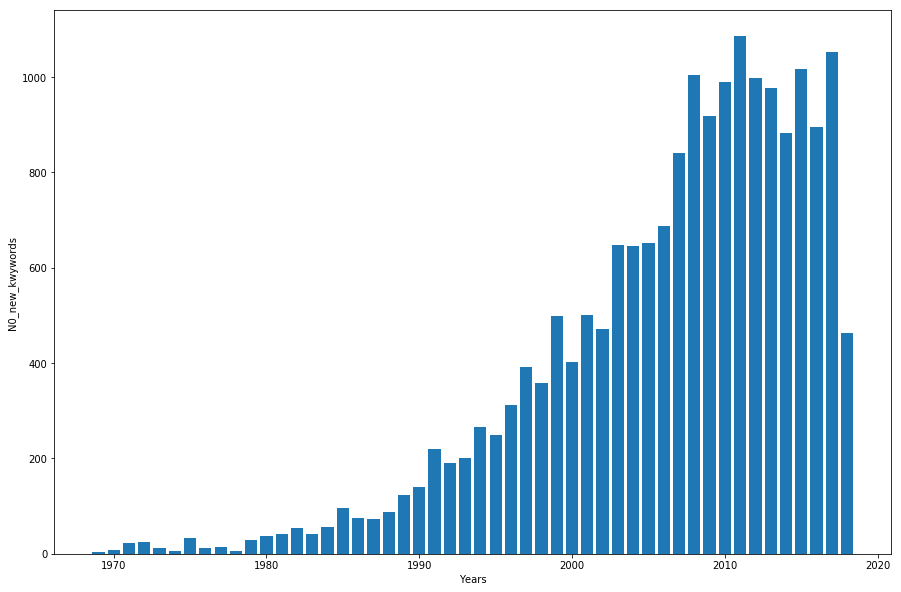

In [8]:
d={"New_keywords":df_new_keyword,"Year":df_year}
import pandas
df=pandas.DataFrame(data=d)
df=df[df.New_keywords != 0]
plt.figure(figsize=(15,10))
x_pos = list(range(len(df["Year"])))
plt.bar(df["Year"],df["New_keywords"])
plt.xlabel("Years")

plt.ylabel("N0_new_kwywords")
#plt.savefig("")
    

In [12]:
for y in keyphraseTracker1.top():
    print str(y.getPhrase())+", "+str(y.sum())

apis mellifera, 3389
honeybee, 1041
honey bee, 920
varroa destructor, 505
honey bees, 504
pollination, 447
honeybees, 315
honey, 256
foraging, 209
pollen, 207
propolis, 186
hymenoptera, 183
apis cerana, 162
nosema ceranae, 158
bees, 155
varroa jacobsoni, 148
insect, 144
royal jelly, 139
apis, 134
social insects, 125
american foulbrood, 119
apidae, 118
paenibacillus larvae, 106
learning, 103
beekeeping, 102
pollinators, 98
nectar, 97
pesticides, 95
nosema apis, 93
gene expression, 93
juvenile hormone, 91
reproduction, 89
division of labor, 89
nutrition, 85
waggle dance, 82
olfaction, 81
bee venom, 81
apis mellifera carnica, 77
varroa, 77
imidacloprid, 77
aethina tumida, 76
resistance, 76
bombus, 74
stingless bees, 73
communication, 73
melittin, 73
bee, 72
mitochondrial dna, 69
mtdna, 68
conservation, 68
insects, 67
apis mellifera l., 67
apis mellifera scutellata, 67
apis mellifera capensis, 66
pollinator, 66
behavior, 66
deformed wing virus, 65
vitellogenin, 63
development, 62
toxicity,

cbpv, 5
canary islands, 5
europe, 5
coloss beebook, 5
community, 5
axis formation, 5
honey bee larvae, 5
nutritional stress, 5
retina, 5
spectroscopy, 5
hornet, 5
flower colour, 5
mediterranean, 5
insulin, 5
geitonogamy, 5
cage, 5
bee diseases, 5
frap, 5
sensitivity, 5
domestication, 5
persistence, 5
metabolite, 5
yungas, 5
10-hydroxy-2-decenoic acid, 5
medicinal plants, 5
horizontal transmission, 5
fecundity, 5
germplasm preservation, 5
osmia cornifrons, 5
nurse bee, 5
9-oxo-2e-decenoic acid, 5
recognition, 5
insect neuropeptide, 5
fertility signal, 5
entrainment, 5
genetic structure, 5
mitotype, 5
brassica rapa, 5
next-generation sequencing, 5
glycine max, 5
blooming, 5
immune system, 5
carniolan honey bee, 5
apocynaceae, 5
intestine, 5
honey sac, 5
royal jelly (rj), 5
hummingbirds, 5
histochemistry, 5
lactobacillus kunkeei, 5
precision apiculture, 5
rna, 5
cape, 5
chemosensory protein, 5
honeybee (apis mellifera l.), 5
horizontal gene transfer, 5
hemocytes, 5
vitality, 5
nitidulidae

microtubules, 3
hexane, 3
fly, 3
hive entrance fittings, 3
envenomation, 3
simulation, 3
fruit quality, 3
mandibular gland secretion, 3
hybrid seed production, 3
artificial bee colony, 3
ovule discounting, 3
interference, 3
food-anticipatory activity, 3
exoskeleton, 3
discriminant function analysis, 3
spinosad, 3
cucumis melo l, 3
telomere, 3
marker-assisted selection, 3
honeybee genome, 3
corbicular pollen, 3
risk sensitivity, 3
body mass, 3
cancer, 3
motion detection, 3
nectar composition, 3
citral, 3
habitat loss, 3
nestedness, 3
trypanosoma cruzi, 3
alfalfa, 3
selective breeding, 3
pupa, 3
treatment efficacy, 3
burkina faso, 3
entomopathogenic fungus, 3
mast cell, 3
shape discrimination, 3
epidermal growth factor receptor, 3
ceratitis capitata, 3
lactate dehydrogenase, 3
trypsin, 3
olfactory bulb, 3
plant extract, 3
tyrosine, 3
fluorescence, 3
landscape structure, 3
mating flights, 3
rna editing, 3
deterrent, 3
aggressive behavior, 3
hybrid, 3
pesticide toxicity, 3
excretion, 3
res

nest cavity, 2
allergen-specific immunotherapy, 2
vasopressin, 2
encapsulation response, 2
pyrethroid insecticide, 2
comb vibration, 2
alpha-linolenic acid, 2
piggybac, 2
glutathione s-transferases, 2
genome size, 2
social interactions, 2
bacillus subtilis subsp. subtilis, 2
infectivity, 2
species, 2
consolidation, 2
microinjection, 2
open brood, 2
fanning, 2
projection neuron, 2
meiotic recombination, 2
stable isotopes, 2
local foods, 2
unloading rate, 2
cardiotoxicity, 2
earthworms, 2
chaotic local search, 2
natural history, 2
queen balling, 2
scouts, 2
calliphoridae, 2
lucerne, 2
nigeria, 2
lactobacillus spp, 2
beevital hive clean, 2
raman spectroscopy, 2
floral source, 2
fragaria x ananassa, 2
african honeybees, 2
hive weight, 2
amino acid sequence, 2
syrphid fly, 2
cripavirus, 2
oleic acid, 2
fine mapping, 2
tbars, 2
flower number, 2
lethal time, 2
performances, 2
confinement, 2
daily activity, 2
non-natal parasitism, 2
lizard-pollination, 2
reproductive behaviour, 2
caries, 2
fli

broad-complex, 1
national park management, 1
resin crop, 1
saccoglossus kowalevskii, 1
white spot syndrome virus, 1
silkworms, 1
transmission mode, 1
epigenome, 1
non-apis bee conservation, 1
individual effect, 1
motion parallax, 1
acc-royalisin, 1
night-sheltering, 1
diflubenzuron, 1
toxic alkaloid, 1
fluoroquinolones, 1
black cumins, 1
cd203c, 1
myclobutanil, 1
bee cake, 1
agroecological zones, 1
terrestrial toxicity, 1
preimaginal weight loss, 1
queens anomalies, 1
prince edward island, 1
eremochloa ophiuroides, 1
metalloproteases, 1
(e)-3-heptene-2,5-dione, 1
dandelion pollen, 1
derivatives, 1
flower biology, 1
cheating, 1
phytochemical, 1
kiwifruit pollination, 1
tool plants, 1
climatic season, 1
micropropagation, 1
thyreus, 1
c2 phylogenetic group, 1
extracellular production, 1
dnp, 1
natural membrane, 1
empty frames, 1
eucalyptus type propolis, 1
real-time pcr detection, 1
impatiens glandulifera royle, 1
wire-netting, 1
females, 1
epitopes, 1
voi, 1
sensitivity to reward, 1
lang

plant disease, 1
eucalyptus largiflorens, 1
cystatin, 1
honey bee forager, 1
renewable energy, 1
emr-lipid, 1
salt tolerance, 1
bovine, 1
signal repetition, 1
serial sectioning, 1
colony sample size, 1
karyotype, 1
spring ephemerals, 1
genome sequence, honeybees, algeria, north africa, 1
caffeoylquinic acid, 1
mycoflora, 1
g6pase, 1
lysiphlebus fabarum, 1
cytb, 1
high throughput genomics, 1
mass flowering, 1
aniline blue, 1
equatorial region, 1
seed weight, 1
honeybee (apis mellifera) workers and drones, 1
internet, 1
chemosensory receptors, 1
hch, 1
pollen stress, 1
dry-forest, 1
flower visitation rate, 1
electrostatic pollination, 1
evolution of aging, 1
cordia leucocephala, 1
royal jelly glycoproteins, 1
prunus cerasus cv., 1
stability program, 1
supplemental pollination, 1
wax ester, 1
withdrawal time, 1
introduced crop pollinators, 1
receptive field, 1
dose response, 1
centaurea mollis, 1
savannah honey bee, 1
conservation islands, 1
natural resources, 1
near intron pair (nip), 1


immune related genes, 1
data sharing algorithm, 1
temperature sensing, 1
meliponula, 1
varroa-sensitive hygiene, 1
burkholderia, 1
plant protection product, 1
adult honey bees, 1
video link, 1
passion fruit, 1
hypertrehalosaemic factors, 1
symbioses, 1
megachille sp., 1
ginsenoside re, 1
developmental phases, 1
whirligig, 1
flight directionality, 1
maldims profiling, 1
uniqueness, 1
virulence evolution, 1
metarhzium sp., 1
resources, 1
brood thermoregulation, 1
insect cholinesterase, 1
virus evolution, 1
family-b gpcr, 1
multiple phase neighborhood search-grasp, 1
clover (trifolium repens), 1
centipede grass, 1
face recognition, 1
tulsi, 1
southern europe, 1
fungistatic activity, 1
period mrna, 1
hygienic queens, 1
synergy bee venoms, 1
stylisma, 1
porcine reproductive and respiratory syndrome virus, 1
caste dimorphism, 1
decision tree analysis, 1
2d-page, 1
behavioral resistance, 1
pedicularis rex, 1
cancer chemoprevention, 1
camassia quamash, 1
systematic surveillance, 1
hatching rat

palaeontology, 1
non-autonomous, 1
detoxification systems, 1
foraging density, 1
thermogravimetry analysis, 1
body size variation, 1
colony defence behaviour, 1
brood pheromones, 1
optimization model, 1
tyrocidine, 1
musella lasiocarpa, 1
colony level selection, 1
accelerated solvent extraction (ase), 1
therapeutics, 1
nectar-feeding passerines, 1
seed predation, 1
rice delphacid, 1
branch and bound algorithm, 1
gut endocrine cells, 1
co-citation network, 1
tracheal ducts, 1
conditional process modelling, 1
environmental analysis, 1
sensory coding, 1
free choice profile, 1
invertebrate learning and perception, 1
drug delivery, 1
circular dichroism spectroscopy, 1
semi-natural grassland, 1
stimulus asynchrony, 1
wintergreen oil, 1
afrotropical, 1
german cockroach, 1
apis mellifera rodopica, 1
electric stimuli, 1
economic viability, 1
sting phernomones, 1
rfid tags, 1
interfaces, gc-ms, 1
insecticidal action, 1
candida spp., 1
insect-flower interaction, 1
alcohol addiction, 1
molecular p

laccase2, 1
decs, 1
anti-ige high dilution, 1
trophic resources, 1
bee-gut microbiota, 1
kin-selection, 1
pollen storage, 1
saccharides, 1
biotechnological applications, 1
world organisation for animal health, 1
cynodon dactylon, 1
diutinus bees, 1
skin irritaion, 1
honeybees' pathogen, 1
pseudomonas syringae pv. actinidiae, 1
sumoylation, 1
hyperthermia, 1
brood rearing in laboratory conditions, 1
uvb irradiation, 1
clip domain, 1
morphometric traits, 1
organosilicon, 1
honeybee forewing, 1
elaeagnus angustifolia, 1
methyl-p-hydroxybenzoate (hob), 1
arable land, 1
advanced eusociality, 1
apis mellifera queens, 1
summer seed watermelon, 1
spring treatments, 1
effective pollinators, 1
heliothis virescens, 1
infectious diseases, 1
malpighiaceae, 1
phosphorus 30 ch, 1
negative binomial distribution, 1
biopolymer, 1
feeding station, 1
p-coumaric acid, 1
asymmetric dominance, 1
hypopharyngeal secretions, 1
ancestry informative markers, 1
mediterranean type climates, 1
black seed, 1
alternat

cognitive ethology, 1
bt maize, 1
korean honeybee, 1
transition dances, 1
computational biology, 1
resource partition, 1
aerodynamics wind tunnel, 1
momordica charantia, 1
antennal mechanosensory system, 1
social transmission, 1
hyposensitization, 1
chronic intoxication, 1
ecg, 1
genetic response, 1
role change, 1
retinue pheromone, 1
methylselenocysteine, 1
yield and quality properties, 1
ocimum basilicum, 1
brood size, 1
bleaching, 1
tert-butyl hydroperoxide, 1
ecr, 1
intron/exon evolution, 1
caucasican honeybees, 1
ornamental woody plants, 1
sex linkage, 1
mitochondrial lineages, 1
myotoxins, 1
tree hole availability, 1
geometry, 1
nesting dynamics, 1
mite abundance, 1
citricultura, 1
decentralized algorithm, 1
polar tube proteins, 1
satureja odora, 1
cage experiment, 1
illumina-solexa sequencing, 1
geographic cline analysis, 1
prefractionation, 1
potentilla reptans var. sericophylla, 1
pcbs, 1
date of sowing, 1
imidaclorpid, 1
heat shock protein 8, 1
disembodied, 1
collective intel

est-s allele, 1
ft-ir spectroscopy, 1
mucosubstances, 1
physical manipulation, 1
egg-eating, 1
nonlethal, 1
hyaluronidase inhibitors, 1
pheromone trap, 1
bombus impatiens (cresson 1863), 1
bee mites, 1
subjective evaluation, 1
asclepias meadii, 1
bulbus, 1
antirhinnum majus, 1
saddle-node bifurcation, 1
selective toxicity, 1
reward system, 1
post-ingestive feedback, 1
graft, 1
broodcare, 1
marking, 1
meta-barcoding, 1
cold adaptation, 1
grazing intensity, 1
complex traits, 1
air pouch, 1
visual behavior, 1
insect trapping, 1
acetyl transferase, 1
occluded corolla, 1
gram-positive bacteria, 1
chiasmognathus, 1
in vitro fluorescent antibody, 1
handicap, 1
felt, 1
colony level traits, 1
subfunctionalization, 1
fluorescent dust marking, 1
prunus cerasus, 1
high five insect cell, 1
orange groves, 1
1h nmr-based metabolomics, 1
newborn infants, 1
floral biodiversity, 1
potato, 1
trigona biroi, 1
shelf-life, 1
chitinases, 1
reinsemination, 1
rna-sequencing, 1
formica polyctena, 1
genetic back

residence time, 1
behavioural patterns, 1
1-hexanol, 1
animal cognition, 1
transpiration, 1
microbial prevalence, 1
canopy biology, 1
individual, 1
elastase, 1
genomic, 1
component resolved diagnosis, 1
durio zibethinus, 1
kappab sites, 1
interspecific interactions, 1
microbial biology, 1
flower-visitingrecords, 1
philanthus triangulum (beewolf), 1
live weights, 1
relic floral features, 1
accumulation factor, 1
beeclinic, 1
differential evolution, 1
feral honeybee, 1
gynodioecy, 1
stenopodainae, 1
epigenetic variation, 1
human dermal fibroblast, 1
hippocampus, 1
sensory descriptive analysis, 1
nutritional chemistry, 1
hail net, 1
analogues, 1
guard bee behavior, 1
recurrent networks, 1
family farming, 1
in vivo experimental model, 1
energy costs, 1
seed-set and cross pollination, 1
swidden, 1
polybia scutellaris, 1
grouping analysis, 1
amazona vinacea, 1
aegean ecotype, 1
falling mites, 1
relaxed constraint, 1
trichodex, 1
abdominal ganglia, 1
mast cell degranulation, 1
queen attractiv

b. terrestris, 1
winter 2007/2008, 1
amelcpr14 gene, 1
cape and radiation, 1
hypoxanthine, 1
methyl anthranilate, 1
microsatellite isolation, 1
aureobasidium pullulons, 1
behavioral biology, 1
simple sequence repeats, 1
chaotic improved honey bee mating optimization, 1
hatay, 1
apis cerana f., 1
agrarian ecosystems, 1
snmp, 1
tilia tomentosa, 1
burning, 1
foraging sites, 1
croton urucurana, 1
hex 110 gene, 1
within-host competition, 1
paracellular permeability enhancer, 1
female castes, 1
coiled-coil, 1
acetylcholinesterase activity rate, 1
glia, 1
differentially expressed gene, 1
pectin, 1
methylated cpg, 1
honey bee glut8, 1
minimal inhibitory concentration (mic), 1
bud resin, 1
bee abundance, 1
ixodes scapularis, 1
horizontal transfer, 1
strand asymmetry, 1
amazon region, 1
ecosystem, 1
microbial phylogeny, 1
inactives, 1
behavioral pharmacology, 1
g - chromosome polymorphism, 1
honey colour, 1
risk factor analysis, 1
primor, 1
plutonium, 1
xbp1, 1
lymnaea stagnalis, 1
hugin gene, 1

neuronal activation, 1
lucilia, 1
a. m. caucasica, 1
winter within-hive mortality, 1
recombinant enzyme, 1
polo, 1
pod, 1
verhulst-pearl model, 1
okadaic acid, 1
nest founding, 1
supernumerary cells, 1
aorta, 1
chronobiology, 1
market access, 1
guinea pig, 1
allatostatin c, 1
protective response of the honey bee larvae, 1
general protein (p-3) polymorphism, 1
atp synthase, 1
acacia spp., 1
pollinator foraging activity, 1
host microbe interactions, 1
mitophagy, 1
vitaceae, 1
honeybee bodies, 1
membrane permeabilization, 1
insect rnai, 1
single-nucleotide polymorphism, 1
amplicons, 1
andromonoecy, 1
flight velocity, 1
ecdysis triggering hormone, 1
protocols, 1
chemosensillae, 1
sps agreement, 1
n-methylindoxylacetate, 1
worker honey-bee, 1
fixative compounds, 1
bee distribution, 1
camponotus, 1
acccpr24, 1
spermathecal glands, 1
l-type ca2+ channels, 1
pollinator assemblages, 1
asclepias exaltata, 1
detoxication, 1
phospholipase c, 1
s. aureus, 1
helleborus foetidus, 1
chicken embryo, 1


embryology, 1
chemical defence, 1
spermatozoa capacitation, 1
neuroplasticity, 1
forest resource use, 1
intra-colony nepotism, 1
cystine knot, 1
value chain approach, 1
calluna vulgaris, 1
flexible cuticle, 1
clinical trials, 1
relearning, 1
optical coherence tomography, 1
protein modeling, 1
tegillarca granosa, 1
dzongu golsey, 1
surface proteolysis, 1
pineapple honey, 1
epc cell line, 1
mating type, 1
cryptic diversity, 1
bartonella apis, 1
worker loss, 1
prenyl cinnamic acid, 1
guttated fluid, 1
beekeeping and climate change, 1
binding pocket, 1
lc<inf>50</inf>, 1
sucrose discrimination, 1
intestinal infection, 1
epipogium aphyllum, 1
callistemon rigidus, 1
baculovirus expression, 1
ethanolic extracts, 1
agrarian reform, 1
ampullacea, 1
signal peptides, 1
aeromonas hydrophila, 1
xanthomonas citri ssp. citri, 1
physiological cost, 1
subunit "d", 1
two-species ess, 1
queen-worker conflicts, 1
orius laevigatus, 1
single flower visit, 1
southwest region of entre, 1
trigona nigra, 1
ribo

In [25]:
len(keyphraseTracker1.top())

18820

In [13]:
y = keyphraseTracker1.words["colony collapse disorder"]
print y.years

{2016: 7, 2017: 5, 2018: 2, 2007: 1, 2008: 3, 2009: 4, 2010: 9, 2011: 2, 2012: 3, 2013: 4, 2014: 2, 2015: 5}


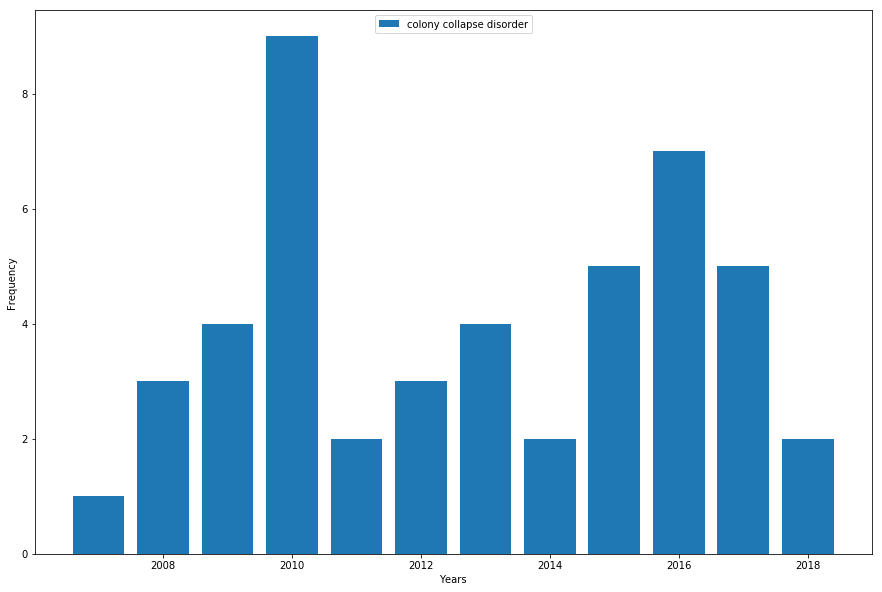

In [35]:
p= docs+'Graph_keywords_years/'+"colony collapse disorder.png"
y = keyphraseTracker1.words["colony collapse disorder"]
a= y.years.keys()
b= y.years.values()
#print(a)
#print(b)
d = {"yr":a,"val":b}
import pandas
df=pandas.DataFrame(data=d)
df=df.sort_values(by=['yr'])
#print(df)
plt.figure(figsize=(15,10))
x_pos = list(range(len(df["yr"])))
plt.bar(df["yr"],df["val"])
plt.xlabel("Years")
plt.legend(["colony collapse disorder"],loc='upper center')

plt.ylabel("Frequency")

plt.savefig("p")

In [10]:
# i=0
# for abstr in selection_edge:
#     phrases = [k.strip() for k in  abstr.keywords.split(";")]
#     phrases = [k.lower() for k in  abstr.keywords.split(";")]
#     print(set(phrases))
#     i +=1
#     print(i)

Text(0,0.5,'Frequency')

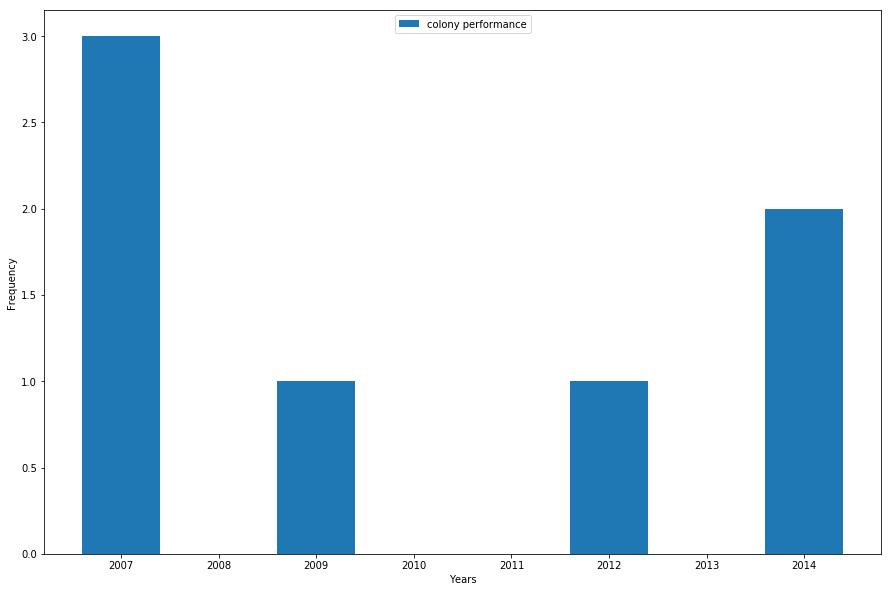

In [45]:

y = keyphraseTracker1.words["colony performance"]
a= y.years.keys()
b= y.years.values()
#print(a)
#print(b)
d = {"yr":a,"val":b}
import pandas
df=pandas.DataFrame(data=d)
df=df.sort_values(by=['yr'])
#print(df)
plt.figure(figsize=(15,10))
x_pos = list(range(len(df["yr"])))
plt.bar(df["yr"],df["val"])
plt.xlabel("Years")
plt.legend(["colony performance"],loc='upper center')

plt.ylabel("Frequency")

    

In [38]:
y.years


{1999: 2, 2001: 1, 2009: 1, 2013: 1, 2014: 2, 2016: 1, 2017: 3}

In [11]:

# for j in ls:
#     w=0
#     for abstr in selection_edge:
#         phrases = [k.strip() for k in  abstr.keywords.split(";")]
#         phrases = [k.lower() for k in  abstr.keywords.split(";")]
#         if (len(set(phrases)) >1):
#             if(j[0] and j[1] in set(phrases)):
#                 w +=1
#     print(w)           
            
        